<a href="https://www.kaggle.com/code/amirhosseinmhd/clusterered-fed-localtrainingtrue?scriptVersionId=146473979" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Clustered Federated Learning

## Constructing a Multi-Layered Graph:

To construct the edge weights $A_{i,i'}$, we first compute the quantities:
$$
\
\hat{c}_i^{(j)} :=  [x_j^{(i, 1)}, \ldots, x_j^{(i, m_i)}]^T [y^{(i, 1)}, \ldots, y^{(i, m_i)}] 
\
$$
Note that the quantity $\hat{c}_i^{(j)}$ is a noisy estimate of $w_j$. For each $j \in \{1, \ldots, d\}$ and local dataset $i$, we construct the edge weights by
$$
\
A_{i,i'}^{(j)} = \begin{cases}
1 & \text{if } \hat{c}_{i'}^{(j)} \text{ is among } k \text{ nearest neighbors of } \hat{c}_i^{(j)} \\
0 & \text{otherwise}
\end{cases}
\
$$



#### Algorithm:
0. Find the multi-layer graph structure of data as explained above.

1. **for** client $i \in [N]$ **do**
   - Send $w^{(i)}_0$ to all clients $j \neq i$.

2. **for** round $t \in [T]$ **do**
   
   3. **for** client $i \in [N]$ **do**
      - Compute the gradient of the cooperative loss function using all training samples:  
        $ L^{(i)}(w^{(i)}) = MSE(w^{(i)}) + \sum_{j=1}^{d} \sum_{i,i'} A^{j}_{(i,i')} (w^{(i)}_{j} - w^{(i')}_{j})^2 $
        
      - Update $w^{(i)}_{t+1}$ with the following rule:

        $w^{(i)}_{t+1}$ = $w^{(i)}_{t}$ - $ \frac{{dL_i(w^{(i)}_{t})}}{{dw^i}}$
        
   4. For L iterations:

       - Update $(w^{(i)}_{t+1})$ with the following rule:

            $w^{(i)}_{t+1} = w^{(i)}_{t+1} - \frac{dMSE(w^{(i)}_{t+1})}{dw^{(i)}}$
   5. Send updated weights to neighbors.


- The gradients are computed using Torch `autograd` module.
- In step (2.D) the local weights are updated locally only w.r.t to their own local samples to improve performance of algorithm.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import torch
import torch.optim as optim
import copy
from sklearn.neighbors import NearestNeighbors
import random
import csv

In [2]:
class Client:
    def __init__(self, n_samples, n_features, weights, true_w, std=0.01):
        self.weights = weights

        self.X, self.y = generate_data(n_samples, n_features,
                                       true_w, std)  
#         self.X_eval, self.y_eval = generate_data(n_samples, n_features, true_w, std)
        self.n_features = n_features
        self.GT_w = true_w
        
    
    def train_locally(self, L):
        weights = self.weights.clone()
        for l in range(0, L):
            weights.requires_grad_()
            weights.grad = None
            prediction = self.X @ weights
            loss_ = ((prediction - self.y) ** 2).mean()
            loss_.backward()
            grad = weights.grad.clone()
            with torch.no_grad():
                weights = weights - 0.01 * grad
        self.weights = weights.detach()
        return weights.detach()

    
    def get_coop_loss_and_grad(self, lambda_, neighbors, weights, mode_):
        weights.requires_grad_()
        weights.grad = None
        prediction = self.X @ weights
        if mode_ == "algo":
            loss_ = cooperative_loss(prediction, self.y, self.n_features, weights, neighbors, lambda_)
        elif mode_ == "oracle":
            loss_ = cooperative_loss_oracle(prediction, self.y, self.n_features, weights, neighbors, lambda_)
        loss_.backward()
        return loss_.item(), weights.grad

    
    def eval(self, weights):
        with torch.no_grad():
            return ((self.GT_w - weights).norm(p=2)).item()


#### Function: get_multi_layer_adj_mat

This function takes a list of clients and a parameter 'k' as input and returns a multi-layer adjacency matrix.

- **Input**:
  - `clients_list`: A list of clients.
  - `k`: The number of neighbors to consider when constructing the adjacency matrix.

- **Output**:
  - `multi_layer_adj_mat`: A (n x n x num_features) matrix where each entry [i, j, k] represents whether the jth client is a neighbor of the ith client in dimension k.

- **Details**:
  - The function calculates a multi-layer adjacency matrix by considering the neighbors of each client in different dimensions.
  - For each client and dimension, it computes a local feature matrix 'c'.
  - It then uses the 'k' nearest neighbors algorithm to construct a binary adjacency matrix for each dimension.
  - Finally, these adjacency matrices are stacked together along the third dimension to create the multi-layer adjacency matrix.

This function is useful for analyzing the neighborhood relationships among clients in various dimensions.


In [3]:

def get_multi_layer_adj_mat(clients_list, k):
    
    lst_arrays = []
    num_clients = len(clients_list)
    c = np.zeros((num_clients, num_features))

    for i in range(0, num_clients):
        for j in range(0, num_features):
            client_temp = clients_list[i]
            c[i, j] = client_temp.X[:, j].reshape(1, -1) @ client_temp.y.reshape(-1, 1)
    neigh = NearestNeighbors(n_neighbors=k)

    for j in range(0, num_features):
        temp = c[:, j].reshape(-1, 1)
        neigh.fit(temp)
        A = neigh.kneighbors_graph(temp)
        lst_arrays.append(A.toarray())

    multi_layer_adj_mat = np.dstack(lst_arrays)
    return multi_layer_adj_mat



#### Function: get_neighbors

This function takes a list of clients and a multi-layer adjacency matrix as input and returns a list of neighbors as Client Class object for each client.

- **Input**:
  - `clients_list`: A list of clients.
  - `multi_layer_adj_mat`: A multi-layer adjacency matrix where each entry [i, j, k] indicates whether the jth client is a neighbor of the ith client in dimension k.

- **Output**:
  - `multi_layer_neigh_list`: A list of neighbors for each client, with neighbors assigned for each feature value in the client's data.

- **Details**:
  - The function first initializes the dimensions where a client would be considered as its own neighbor (i.e., diagonal entries) to 0 in the multi-layer adjacency matrix.
  - It then iterates through each client and dimension, collecting neighbors based on non-zero entries in the multi-layer adjacency matrix.
  - The result is a list of neighbors for each client, where neighbors are defined by their feature values in the multi-layered graph.

This function is useful for analyzing the neighborhood relationships among clients in different dimensions of their data.


In [4]:

def get_neighbors(clients_list, multi_layer_adj_mat):
    '''
    returns a list of neighbors for each client. this neighbors are assigned for each feature values in client's data.
    consider a multi layered graph.
    '''
    num_clients, _, num_features = multi_layer_adj_mat.shape
    for i in range(0, num_clients):
        for j in range(0, num_clients):
            if i == j:
                multi_layer_adj_mat[i, j, :] = 0

    multi_layer_neigh_list = []
    for client_iter in range(num_clients):
        neighbors = []
        for j in range(0, num_features):
            neighbors.append([x for (x, m) in zip(clients_list, multi_layer_adj_mat[client_iter, :, j]) if m])
        multi_layer_neigh_list.append(neighbors)

    return multi_layer_neigh_list


In [5]:

def generate_data(n_samples, n_features, true_w, std):
    """Generate synthetic data for a user."""
    X = torch.randn(n_samples, n_features, dtype=torch.float64)
    y = X @ true_w  + std * torch.randn(n_samples, 1)
    return X, y


def cooperative_loss(pred, target, n_features, weights, multi_layer_neighbor_list, lambda_):
    mse_loss = ((pred - target) ** 2).mean()

    variation_loss = 0.0
    for j in range(0, n_features):
        neighbors = multi_layer_neighbor_list[j]
        #         print(neighbors)
        for neighbor in neighbors:
            variation = (weights[j] - neighbor.weights[j]).pow(2)
            variation_loss += variation
    return mse_loss + lambda_ * variation_loss

def cooperative_loss_oracle(pred, target, n_features, weights, neighbors, lambda_):
    mse_loss = ((pred - target) ** 2).mean()
#     print("mse loss" + str(mse_loss.shape))
    variation_loss = 0.0
    for neighbor in neighbors:
        variation = (weights - neighbor.weights).pow(2).sum()
        variation_loss += variation
#     print("variation" + str(variation.shape))
    
    return mse_loss + lambda_ * variation_loss


## Prepration of Data and The Graph
Two following code snippets initialize a list of clients for the algorithm:

- `clients_list`: An empty list to hold client objects.
- **Loop over all clients:**
   - `X`: Randomly generated data, realization of normal distribution $ N (μ, σ)$ matrix with $μ=0$ and $σ=I_d$ with size of `(num_features, m)`.
   - `w_init_mat`: Initial estimate of weight vectors of all clients in a giant matrix, and each client's weight vector is realization of Normal(0, I) random variable.
   - `GT_W`: Ground truth weights for the current client, uniformly distributed between -5 and 5.
   - A new `Client` object is created with parameters (`GT_W`, `w`, `m`, `num_features`, `std`) and appended to `clients_list`.
   - `client.y`: This attribute of the client class, is labels of clients' feature. These labels are linear model based on $y = W^T X + n$.
  - The grand truth weight vector `GT_W` is similar for clients in a same cluster.
  - `num_clusters` is the true number of underlying clusters that shape labels.

  The final result is a list of `n` clients, each with randomly initialized data and weights.


In [6]:
num_samples = 10
num_features = 15

lr = 0.015
num_rounds = 1000
lambda_ = 0.5
GT_weight_list = []
std = 0.01
num_clusters = 2
num_clients = 100
train_locally_flag= True
num_local_training_rounds = 20


one_hotted_GT = torch.from_numpy(np.eye(num_clusters)[np.random.choice(num_clusters,
                                                                       num_clients)].T)  # creates a matrix and indicates which client belongs to which cluster it has k rows and n coloumns
core_GT_weights = torch.from_numpy(np.random.uniform(low=-10, high=10, size=(num_features, num_clusters)))  # (d, k)
clients_GT_weights = core_GT_weights @ one_hotted_GT  # (d, n) = (d, k) @ (k, n)
clients_list = []
w_init_mat = torch.randn(num_features, num_clients, requires_grad=False, dtype=torch.float64)
w_init_mat_ind = w_init_mat.clone()
w_init_mat_1 = w_init_mat.clone()

w_grad_mat = torch.zeros((num_features, num_clients), requires_grad=False)

for client_iter in range(num_clients):
    GT_w = clients_GT_weights[:, client_iter].reshape(-1, 1)
    w = w_init_mat[:, client_iter].reshape(-1, 1).clone()
    clients_list.append(Client(num_samples, num_features, w, GT_w, std))

copy_clients_list_copy = copy.deepcopy(clients_list)






## Implementing Algorithm for Different Number of Neighbors

The provided code implements the algorithm while varying the number of neighbors for each client when constructing a graph using kNN. In essence, it is an experiment to assess the impact of the variable 'k' on the algorithm's performance.

In [7]:
num_neighbours_list = [2, 4, 8, 12, 25, 40]
list_loss_tot_1_lambda = []
for l in range(len(num_neighbours_list)):
    clients_list = copy.deepcopy(copy_clients_list_copy)
    list_loss_tot_1 = []
    num_neighbours = num_neighbours_list[l]
    multi_layer_adj_mat = get_multi_layer_adj_mat(clients_list, num_neighbours)
    multi_layer_neigh_list = get_neighbors(clients_list, multi_layer_adj_mat)
    w_current = w_init_mat.clone()
    
    
    for round_ in range(0, num_rounds):

        list_loss_1 = []


        for client_iter in range(0, num_clients):
            w = w_current[:, client_iter].clone().reshape(-1, 1)
            loss, w_grad = clients_list[client_iter].get_coop_loss_and_grad(lambda_, multi_layer_neigh_list[client_iter], w, "algo")
            w_grad_mat[:, client_iter] = w_grad.clone().squeeze()

#             list_loss_1.append(clients_list[client_iter].eval(w.detach()))
            list_loss_1.append(clients_list[client_iter].eval(w.detach()))
        w_current = w_current - lr * w_grad_mat.clone()

        for client_iter in range(num_clients):
            clients_list[client_iter].weights = w_current[:, client_iter].clone().reshape(-1, 1)
        
        if train_locally_flag:
            for client_iter in range(0, num_clients):
                w = clients_list[client_iter].train_locally(num_local_training_rounds)
                w_current[:, client_iter] = w.clone().squeeze()
            
        list_loss_tot_1.append(sum(list_loss_1) / len(list_loss_1))
        # list_loss_tot_1.append(loss)
    list_loss_tot_1_lambda.append(list_loss_tot_1)


Finding the performance when we train independently:

In [8]:
clients_list = copy.deepcopy(copy_clients_list_copy)
list_loss_tot_ind = []

w_current = w_init_mat.clone()
for round_ in range(0, num_rounds):

    list_loss_ind = []
    for client_iter in range(0, num_clients):
        list_loss_ind.append(clients_list[client_iter].eval(clients_list[client_iter].weights.detach()))
        clients_list[client_iter].train_locally(1)


    list_loss_tot_ind.append(sum(list_loss_ind) / len(list_loss_ind))
    # list_loss_tot_1.append(loss)


## Finding Performance of Model Using Oracle Approach:

In [9]:
clients_list = copy.deepcopy(copy_clients_list_copy)

w_current = w_init_mat.clone()

clustered_neighbors = []

for j in range(0, num_clusters):
    clustered_neighbors.append([x for (x, m) in zip(clients_list, (one_hotted_GT[j, :] == 1).numpy()) if m])

list_loss_tot_oracl = []
for round_ in range(0, num_rounds):

    list_loss_oracl = []


    for client_iter in range(0, num_clients):
        w = w_current[:, client_iter].clone().reshape(-1, 1)
        current_cluster = torch.argmax(one_hotted_GT[:, client_iter]).item()

        neigh_list = clustered_neighbors[current_cluster]
        loss, w_grad = clients_list[client_iter].get_coop_loss_and_grad(lambda_, neigh_list, w, "oracle")
        
        w_grad_mat[:, client_iter] = w_grad.clone().squeeze()

        list_loss_oracl.append(clients_list[client_iter].eval(w.detach()))

    w_current = w_current - lr * w_grad_mat.clone()

    for client_iter in range(num_clients):
        clients_list[client_iter].weights = w_current[:, client_iter].clone().reshape(-1, 1)
    if train_locally_flag:
            for client_iter in range(0, num_clients):
                w = clients_list[client_iter].train_locally(num_local_training_rounds)
                w_current[:, client_iter] = w.clone().squeeze()
    list_loss_tot_oracl.append(sum(list_loss_oracl) / len(list_loss_oracl))
    # list_loss_tot_1.append(loss)


## Finding Performance of Algorithm for a Case that We Connect All Together

In [10]:
clients_list = copy.deepcopy(copy_clients_list_copy)

w_current = w_init_mat.clone()

list_loss_tot_stup = []
for round_ in range(0, num_rounds):

    list_loss_stup = []


    for client_iter in range(0, num_clients):
        w = w_current[:, client_iter].clone().reshape(-1, 1)
        loss, w_grad = clients_list[client_iter].get_coop_loss_and_grad(lambda_, clients_list, w, "oracle")
        
        w_grad_mat[:, client_iter] = w_grad.clone().squeeze()

        list_loss_stup.append(clients_list[client_iter].eval(w.detach()))

    w_current = w_current - lr * w_grad_mat.clone()

    for client_iter in range(num_clients):
        clients_list[client_iter].weights = w_current[:, client_iter].clone().reshape(-1, 1)
    if train_locally_flag:
            for client_iter in range(0, num_clients):
                w = clients_list[client_iter].train_locally(num_local_training_rounds)
                w_current[:, client_iter] = w.clone().squeeze()
    list_loss_tot_stup.append(sum(list_loss_stup) / len(list_loss_stup))
    # list_loss_tot_1.append(loss)


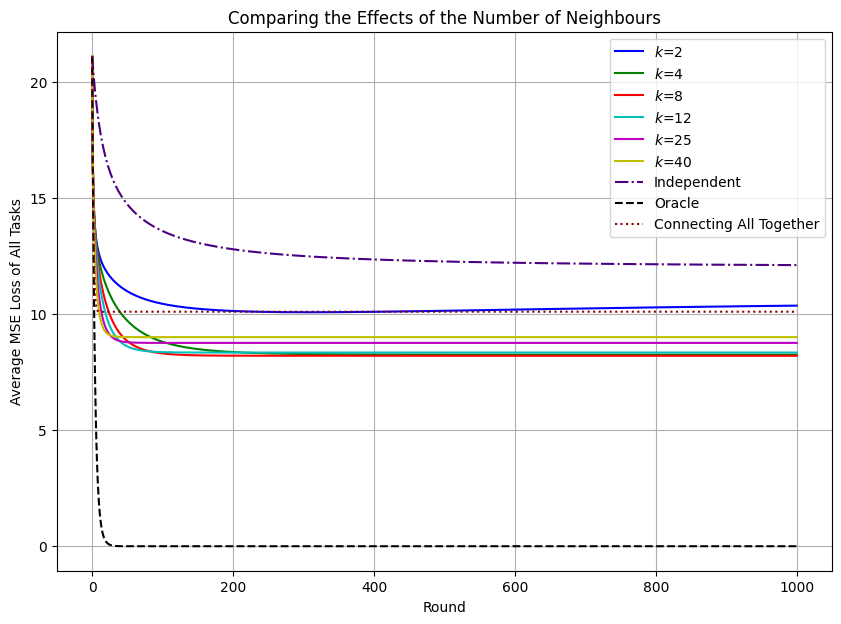

In [11]:
plt.figure(figsize=(10, 7))
x = np.arange(num_rounds)

# Define a list of line styles and colors for better readability
line_styles = ['-', '--', '-.', ':']
colors = ['b', 'g', 'r', 'c', 'm', 'y']

# Plotting lines with different styles, colors, and markers
for i, k in enumerate(num_neighbours_list):
    plt.plot(x, list_loss_tot_1_lambda[i], label=f'$k$={k}',
             linestyle='-', color=colors[i % len(colors)])
plt.plot(x, list_loss_tot_ind, label=f'Independent', linestyle='-.', color='indigo')
plt.plot(x, list_loss_tot_oracl, label=f'Oracle', linestyle='--', color='k')
plt.plot(x, list_loss_tot_stup, label=f'Connecting All Together', linestyle=':', color='darkred')

plt.title("Comparing the Effects of the Number of Neighbours")  
plt.xlabel("Round")  
plt.ylabel("Average MSE Loss of All Tasks")
plt.grid(True)  
plt.legend(loc='upper right')
plt.show()

In [12]:
csv_filename = 'effect_k.csv'
data = [x] + list_loss_tot_1_lambda + [list_loss_tot_ind, list_loss_tot_oracl, list_loss_tot_stup]
data = list(map(list, zip(*data)))
with open(csv_filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(data)

print(f'Data saved to {csv_filename}')

Data saved to effect_k.csv
